<a href="https://colab.research.google.com/github/takatakamanbou/ML/blob/2022/ex15note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML ex15noteC

<img width=72 src="https://www-tlab.math.ryukoku.ac.jp/~takataka/course/ML/ML-logo.png"> [この授業のウェブページ](https://www-tlab.math.ryukoku.ac.jp/wiki/?ML/2022)


In [ ]:
# 準備あれこれ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
seaborn.set()

---
## 画像の減色へのクラスタリングの応用
---
クラスタリングの簡単な応用例として，カラー画像を減色する実験をやってみましょう．

一般的なカラー画像は，一つの画素がRGB3つの値から成る3次元のデータと考えることができます．
このデータに K-means 法を適用して $K$ 個のセントロイドを求めます．
それから，各画素の値を，それと最も近いセントロイドの値に置き換えてやれば，$K$通りの色のみでできた画像を作ることができます．

一般的なカラー画像はRGBそれぞれに8bit使ってますので，表せる色の数は
$$
2^8\times 2^8 \times 2^8 = 2^{24}
$$
より

In [ ]:
2**24

です．どれくらい減色できるものかやってみましょう．

In [ ]:
import os
import shutil
import cv2
from sklearn.cluster import KMeans

from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
# 画像をアップロードしてリサイズする関数
#
def getImage(fnbase, whmax=640):

    # Colab へファイルをアップロード
    rv = files.upload() # ファイルをアップロード
    fnorg = list(rv.keys())[0] # ファイル名を取得
    ext = os.path.splitext(fnorg)[1] # 拡張子を取得
    fname = fnbase + ext
    shutil.move(fnorg, fname) # ファイル名を変更
    print(f'{fname} という名前で保存しました')

    # サイズが大きければ縮小
    img = cv2.imread(fname)
    assert img.ndim == 3  # 3次元配列である（カラー画像である）か
    h, w = img.shape[:2]
    w2, h2 = w, h
    if h > w:
        if h > whmax:
            w2, h2 = (w*whmax)//h, whmax
    else:
        if w > whmax:
            w2, h2 = whmax, (h*whmax)//w

    img2 = cv2.resize(img, (w2, h2))
    cv2.imwrite(fname, img2)
    print(f'{fname} の画素数は {w2}x{h2} です')

    return fname

### 学習

In [ ]:
# 学習用の画像をアップロード
fname1 = getImage('image1', whmax=480)
image1 = cv2.imread(fname1)
cv2_imshow(image1)

次のセルを実行すると，`image1`の画素に対して， `KList` で指定したクラスタ数で K-means クラスタリングを行い，その結果を用いて減色した画像を表示します．
クラスタ数が大きい条件では学習に少し時間がかかるでしょう．

In [ ]:
# image1 を学習データとして K-means 法
img = image1

KList = [256, 64, 16, 4]  # クラスタ数 = 減色後の色数
modelList = []
imgList = []
X = img.reshape((-1, 3))
N, D = X.shape

for K in KList:
    # K-means 法の学習
    model = KMeans(n_clusters=K, n_init=3)
    modelList.append(model)
    label = model.fit_predict(X)
    msqe = model.inertia_ / N

    # 学習画像を減色
    centroid = model.cluster_centers_
    Xr = np.empty_like(X)
    for ik in range(K):
        Xr[label == ik, :] = centroid[ik, :]
    img2 = Xr.reshape(img.shape)
    imgList.append(img2)
    cv2_imshow(img2)
    print(f'K = {K}  msqe = {msqe:.3f}')
    print()


### テスト

上記の学習の結果を使って，別の画像を減色してみましょう．


In [ ]:
# 別の画像をアップロード
fname2 = getImage('image2', whmax=480)
image2 = cv2.imread(fname2)
cv2_imshow(image2)

In [ ]:
# image1 で学習した結果を使って image2 を減色
img = image2
X = img.reshape((-1, 3))
N, D = X.shape

for ik, K in enumerate(KList):
    # 画素ごとに所属クラスタを決める
    model = modelList[ik]
    label = model.predict(X)
    msqe = model.inertia_ / N

    # 減色
    centroid = model.cluster_centers_
    Xr = np.empty_like(X)
    for ik in range(K):
        Xr[label == ik, :] = centroid[ik, :]
    img2 = Xr.reshape(img.shape)
    imgList.append(img2)
    cv2_imshow(img2)
    print(f'K = {K}  msqe = {msqe:.3f}')
    print()

#### ★★★ やってみよう ★★★

1. 適当な画像で実験し，何をやっているのか理解しよう．
1. 学習した画像と色の偏り方が似てるもの，似てないもの，両方を使ってテストしてみよう．

---
## モデル選択の話
---

「過適合とモデル選択」の辺りの復習のため，2次元2クラスのデータを識別する問題の例を考えます．

In [ ]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

(200, 2) (200,)


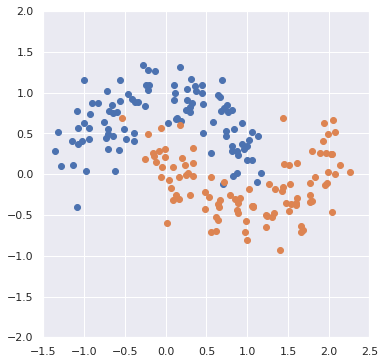

In [ ]:
# 学習データと検証データ
moonXL, moonYL = make_moons(n_samples=200, noise=0.2, random_state=0)
print(moonXL.shape, moonYL.shape)
moonXV, moonYV = make_moons(n_samples=200, noise=0.2, random_state=1)

# グラフを描く
xmin, xmax = -1.5, 2.5
ymin, ymax = -2, 2
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(moonXL[moonYL==0, 0], moonXL[moonYL==0, 1])
ax.scatter(moonXL[moonYL==1, 0], moonXL[moonYL==1, 1])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
plt.show()

識別のための学習モデルとして，ここでは SVM (Support Vector Machine) というものを使います．これがどういうものかは，この授業の範囲を超えていますので，説明しません（興味があれば機械学習関係の参考書等で調べてみてね）．以下では，scikit-learn の [sklearn.svm.SVC クラス](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) を使います



SVM にはいろいろハイパーパラメータがありますが，ここでは，そのうちの一つである「正則化パラメータ」に注目します（注）．以下の図に示すように，この値（以下では `C` と記されています）を変えると，同じ学習データでも異なる識別結果が得られます．

<span style="font-size: 75%">
※注: SVMに興味があるひと向けに注記しておくと，ここでは動径基底関数(radial basis function)をカーネルとしており，そのハイパーパラメータはデフォルトの値としています．
</span>

(200, 200, 2)


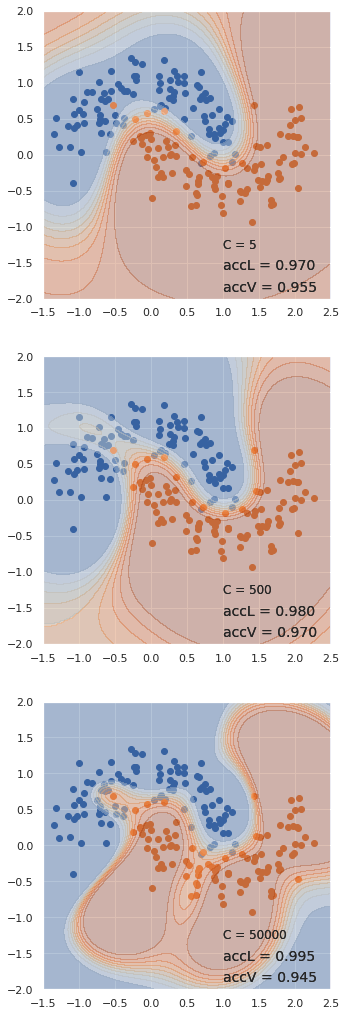

In [ ]:
# 正則化パラメータ
CList = [5, 500, 50000]

# グラフ描画用のグリッドデータの作成
xmin, xmax = -1.5, 2.5
ymin, ymax = -2, 2
x_mesh, y_mesh = np.mgrid[xmin:xmax:0.02, ymin:ymax:0.02]
X_mesh = np.dstack((x_mesh, y_mesh))
print(X_mesh.shape)

accuracyL = []
accuracyT = []

fig, axs = plt.subplots(len(CList), 1, figsize=(6, 6*len(CList)))

for i, C in enumerate(CList):

    # SVM の学習
    model = SVC(C=C, kernel='rbf', gamma='scale', probability=True)
    model.fit(moonXL, moonYL)
    accL = model.score(moonXL, moonYL)
    accV = model.score(moonXV, moonYV)

    # 事後確率の推定
    P = model.predict_proba(X_mesh.reshape(-1, 2))
    P = P.T.reshape((-1, X_mesh.shape[0], X_mesh.shape[1]))

    # 散布図と識別境界
    axs[i].set_xlim(xmin, xmax)
    axs[i].set_ylim(ymin, ymax)
    axs[i].set_aspect('equal')
    cmap = ['Blues', 'Oranges', 'Greens']
    levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for k in range(2):
        axs[i].scatter(moonXL[moonYL==k, 0], moonXL[moonYL==k, 1])
        axs[i].contourf(x_mesh, y_mesh, P[k], levels=levels, cmap=cmap[k], alpha=0.3)
        axs[i].text(1, -1.3, f'C = {C}', fontsize=12)
        axs[i].text(1, -1.6, f'accL = {accL:.3f}', fontsize=14)
        axs[i].text(1, -1.9, f'accV = {accV:.3f}', fontsize=14)

plt.show()


図中の `C` は学習に用いた正則化パラメータの値，`accL` は学習データに対する識別率，`accV` は，学習データとは別に用意した検証データに対する識別率を表します．`C` の値を変えると識別境界の複雑さが変化し，それにともなって `accL` と `accV` の値も変化しています．
`accL` が高いからといって `accV` も高いとは限らないこともわかります．
授業で説明した通りですね．



ここでは学習データとは別に用意したデータを用いて汎化性能を検証しましたが，データが潤沢に手に入る状況でない場合，そういう贅沢はできません．そのような場合には，学習データの一部を学習に使わずとっておいて，学習後の検証に使う，交差検証という方法を使ったりするのでした．

試しに，scikit-learn に用意されている，交差検証(Cross Validation)を自動でやってくれる機能を使ってみます（ [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ）．

In [ ]:
# パラメータのディクショナリ
parameters = {'C':[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]}
# 学習モデル
svc = SVC(kernel='rbf', gamma='scale')
# 5分割交差検証
models = GridSearchCV(svc, parameters, cv=5, return_train_score=True)
models.fit(moonXL, moonYL)

# それぞれのモデルのスコア（学習データおよび検証データに対する識別率の平均）
results = models.cv_results_
for i, params in enumerate(results['params']):
    C = params['C']
    scoreL = results['mean_train_score'][i]
    scoreT = results['mean_test_score'][i]
    print(f'C = {C}   scoreL = {scoreL:.3f}   scoreT = {scoreT:.3f}')

`C` の値を一つ決めたモデルごとに，5分割交差検証によって5通りの識別率を求めてその平均をとっています．`scoreL` が学習データに対する識別率，`scoreT` が（学習データを分割して作った）テストデータに対する識別率です．



#### ★★★ やってみよう ★★★

1. 上記の内容は，この授業の「汎化と過適合」の回の内容の一部の復習となっています．分からないところがあれば授業の notebook や動画を見直そう
1. 5分割交差検証の結果，最も汎化性能が高いと推測されるモデルパラメータ `C` はいくつだったのかメモしておきましょう．

---
## 密度推定の猫画像生成への応用
---


猫画像のデータに正規分布を当てはめれば，その正規分布に従う乱数を生成することで，猫画像を無限に生成することが可能となります．やってみましょう．

ただし，以下で扱う猫画像は画素数が $64\times 64 = 4096$ もありますので，主成分分析による次元削減も併用することにします．こんな感じです．

1. $D=4096$次元の学習データ $\{ \mathbf{x}_n \}$ に主成分分析を適用して，$H(\le D)$次元へと変換する行列 $W_H$ を求める．
1. 学習データを $H$ 次元へと変換したデータ $\{ \mathbf{y}_n | \mathbf{y}_n = W_H(\mathbf{x}_n - \bar{\mathbf{x}})\}$ に $H$ 次元の正規分布を当てはめる（平均と分散共分散行列を推定する）．
1. その正規分布に従う乱数を発生させ，$H$次元のデータ $\widetilde{\mathbf{y}}$ を生成する．
1. 逆変換によって $D$ 次元の猫画像を作る: $\mathbf{z} = W_H^{\top}\widetilde{\mathbf{y}} + \bar{\mathbf{x}}$

In [ ]:
from google.colab.patches import cv2_imshow
from scipy.stats import multivariate_normal

In [ ]:
#####  データの最初の nx x ny 枚を可視化
#
def mosaicImage(dat, nx, ny, nrow=64, ncol=64, gap=4):

    # 並べた画像の幅と高さ
    width  = nx * (ncol + gap) + gap
    height = ny * (nrow + gap) + gap

    # 画像の作成
    img = np.zeros((height, width), dtype = int) + 128
    for iy in range(ny):
        lty = iy*(nrow + gap) + gap
        for ix in range(nx):
            if iy*nx+ix >= dat.shape[0]:
                break
            ltx = ix*(ncol + gap) + gap
            img[lty:lty+nrow, ltx:ltx+ncol] = dat[iy*nx+ix, :].reshape((nrow, ncol))
            
    return img


In [ ]:
# 猫画像データを入手
! wget -nc https://www-tlab.math.ryukoku.ac.jp/~takataka/course/PIP/cat131.npz
cat = np.load('cat131.npz')['cat131']
print(cat.shape) # 131枚，ひとつの画像は 64 x 64 = 4096 画素のグレイスケール画像

# 学習データの最初10個
img = mosaicImage(cat, 5, 2)
cv2_imshow(img)

In [ ]:
# 主成分分析

# データの平均を 0 にする
Xm = np.mean(cat, axis=0)
X = cat - Xm
N, D = X.shape
print(X.shape)
cv2_imshow(Xm.reshape(64, 64))

# X の分散共分散行列の固有値と固有ベクトルを求める
_, sval, Vt = np.linalg.svd(X, full_matrices=False)
eval = sval**2/N
print('固有値:', eval)
U = Vt

In [ ]:
# 次元削減したデータに正規分布を当てはめる

H = 32  # 変換後の次元数

# H 次元へ変換
Y = X @ U[:H, :].T
print(Y.shape)

# 正規分布の当てはめ．PCAしたデータの平均は 0 で分散共分散行列は対角行列
mu = np.zeros(H)
cov = np.mean(Y**2, axis=0)
print(mu)
print(cov)

In [ ]:
# 正規分布の乱数を作り，それを逆変換して画像を生成
Yt = multivariate_normal.rvs(mean=mu, cov=cov, size=25)
print(Yt.shape)
Z = Yt @ U[:H, :] + Xm
print(Z.shape)

# 画素値の範囲 [0, 255] をはみ出した値の処理
ZZ = Z.reshape(-1)
ZZ[ZZ < 0] = 0
ZZ[ZZ > 255] = 255
print(np.min(Z), np.max(Z))

# 可視化
img = mosaicImage(Z, 5, 5)
cv2_imshow(img)

上記の最後のセルは，実行するたびに乱数を生成して新しい猫画像を生み出すことができます．

#### ★★★ やってみよう ★★★

1. いろんな猫を生成してみよう
1. 上記の内容は，この授業の「密度推定」や「主成分分析」の回の内容の一部の復習となっています．分からないところがあれば授業の notebook や動画を見直そう